In [20]:
### for 80mpc box
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re

def unPackRawFile(raw_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
    
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def unPackRawFlux(flux_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y2 = np.genfromtxt(flux_path, skip_header=1, delimiter=' , ')
    velocity = y2[:,0]
    flux = y2[:,1] 
    return velocity, flux

def hubble_flow_convert(velocity, a, omega_m, omega_lam):
    """
    - uses hubble flow to convert from velocity to distance
    """
    aH = a * 100 * (omega_m / a ** 3 + omega_lam)** 0.5
    return velocity/aH

def resample(distance, item, new_distance):
    """
    - interpolates the distances so that we can resample. useful because the velocity after converting using hubble flow doesn't have the same positions as the underlying properties.
    - creates a consistent distance scale (obviously these distances are messed up by peculiar velocities)
    """
    f = interp.interp1d(distance, item)
    new_item = f(new_distance)
    
    return new_item
def getDir(path_LOS,linenumber=7):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)

    return arr

def getPos(path_LOS,linenumber=7):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def get_galaxies(gals, path_LOS, number,Lbox = 80,aexp = 0.1452):
    """
    function can take in the path of the galaxy file (.res) and the line of sight. Number should match the LOS #
    """   
    # Parameter
    #Lbox = 80  # box size
    #aexp = 0.1452  # scale factor for the epoch
    OmegaM = 0.3036
    h100 = 0.6814    # normalized Hubble constant
    pos = np.array(getPos(path_LOS))  # origin of LOS
    pos = pos/512*80
    sphere_los = np.array(getDir(path_LOS))  # direction of LOS , np.sum(e3**2) should be = 1
    e3 = convertSphereToCart(sphere_los[0], sphere_los[1])

    sfr = gals[0] # SFR
    xg = gals[1] #\
    yg = gals[2] # | positions of the galaxies in cMpc/h
    zg = gals[3] #/
    vx = gals[4] #\
    vy = gals[5] # | velocities of the galaxies in km/s
    vz = gals[6] #/
    
    out_arr = Box(Lbox, OmegaM, h100, aexp, sfr, xg, yg, zg, vx, vy, vz, pos, e3)
    num_arr = number*np.ones(len(out_arr.T))
                
    return np.vstack([out_arr, num_arr])

def Box(Lbox, OmegaM, h100, aexp, sfr, xg, yg, zg, vx, vy, vz, pos, e3):
    """
    Wraps LOS to the original box (0-80), helper function for get galaxies.
    """
    ##### find intersection between LOS and grid
    planeNormal = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    if e3[0] > 0:
        planePoint_x = np.array([[80, 0, 0],[160, 0, 0],[240, 0, 0]])
        planePoint_x_inverse = np.array([0,0,0])
    else:
        planePoint_x = np.array([[0, 0, 0],[-80, 0, 0],[-120, 0, 0]])
        planePoint_x_inverse = np.array([80,0,0])
    if e3[1] > 0:
        planePoint_y = np.array([[0, 80, 0],[0, 160, 0],[0, 240, 0]])
        planePoint_y_inverse = np.array([0,0,0])
    else:
        planePoint_y = np.array([[0, 0, 0],[0, -80, 0],[0, -160, 0]])
        planePoint_y_inverse = np.array([0,80,0])
    if e3[2] > 0:
        planePoint_z = np.array([[0, 0, 80],[0, 0, 160],[0, 0, 240]])
        planePoint_z_inverse = np.array([0,0,0])
    else:
        planePoint_z = np.array([[0, 0, 0],[0, 0, -80],[0, 0, -160]])
        planePoint_z_inverse = np.array([0,0,80])
    
    planePoint = np.vstack((planePoint_x,planePoint_y,planePoint_z))
    intercept_pts = LinePlaneIntersection(planeNormal=planeNormal, planePoint=planePoint, losDirection=e3, losPoint=pos)
    intercept_pts[:,0][0:3] = planePoint_x[:,0]
    intercept_pts[:,1][3:6] = planePoint_y[:,1]
    intercept_pts[:,2][6:] = planePoint_z[:,2]

    planePoint_inverse = np.vstack((planePoint_x_inverse,planePoint_y_inverse,planePoint_z_inverse))
    intercept_pts_inverse = LinePlaneIntersection(planeNormal=planeNormal, planePoint=planePoint_inverse, losDirection=(-1)*e3, losPoint=pos)
    for i in range(3):
        intercept_pts_inverse[i,i] = planePoint_inverse[i,i]
    los_start_pts_inverse = np.where(np.logical_and(e3>0, intercept_pts_inverse == 0), 80, intercept_pts_inverse)
    distance_inverse = (-1)*np.sqrt(np.sum((intercept_pts_inverse-pos)**2,axis=1))

    distance = np.sqrt(np.sum((intercept_pts-pos)**2,axis=1))
    new_los_start_pts = np.vstack((pos,intercept_pts[distance<270]%80))
    new_los_start_pts = np.where(np.logical_and(e3<0, new_los_start_pts == 0), 80, new_los_start_pts)
    new_los_start_pts = np.vstack((new_los_start_pts,los_start_pts_inverse))
    x = xg
    y = yg
    z = zg

    new_x = np.tile(x, (len(new_los_start_pts), 1))
    new_y = np.tile(y, (len(new_los_start_pts), 1))
    new_z = np.tile(z, (len(new_los_start_pts), 1))
    w = e3[0]*(new_x-new_los_start_pts[:,0][:, np.newaxis])+\
        e3[1]*(new_y-new_los_start_pts[:,1][:, np.newaxis])+\
        e3[2]*(new_z-new_los_start_pts[:,2][:, np.newaxis])

    dx = new_x - new_los_start_pts[:,0][:, np.newaxis] - w*e3[0]
    dy = new_y - new_los_start_pts[:,1][:, np.newaxis] - w*e3[1]
    dz = new_z - new_los_start_pts[:,2][:, np.newaxis] - w*e3[2]
    new_x = np.where(dx>40,new_x-80,new_x)
    new_x = np.where(dx<-40,new_x+80,new_x)
    new_y = np.where(dy>40,new_y-80,new_y)
    new_y = np.where(dy<-40,new_y+80,new_y)
    new_z = np.where(dz>40,new_z-80,new_z)
    new_z = np.where(dz<-40,new_z+80,new_z)
    w = e3[0]*(new_x-new_los_start_pts[:,0][:, np.newaxis])+\
        e3[1]*(new_y-new_los_start_pts[:,1][:, np.newaxis])+\
        e3[2]*(new_z-new_los_start_pts[:,2][:, np.newaxis])

    dx = new_x - new_los_start_pts[:,0][:, np.newaxis] - w*e3[0]
    dy = new_y - new_los_start_pts[:,1][:, np.newaxis] - w*e3[1]
    dz = new_z - new_los_start_pts[:,2][:, np.newaxis] - w*e3[2]
    distance_all = np.concatenate((np.insert(distance[distance<270],0,0),distance_inverse))[:, np.newaxis]
    w += distance_all

    # distance from the galaxy to the LOS
    dr = np.sqrt(dx**2+dy**2+dz**2)

    # convert w from real to redshift space
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    w += (e3[0]*vx+e3[1]*vy+e3[2]*vz)/aH
    # convert dr from comoving Mpc/h to proper Mpc
    dr *= (aexp/h100)
    sfr = np.tile(sfr, (len(new_los_start_pts), 1))

    # select galaxies
    sel1 = np.logical_and(w>5,w<195) # within first 200 cMpc/h
    sel2 = np.logical_and(dr<2,sfr>1)
    sel = np.logical_and(sel1,sel2)

    
    if(len(sel) > 0):
        sfr1 = sfr[sel]
        w1 = w[sel]
        w1 = np.round(w1,decimals=8)
        dr1 = dr[sel]
        dr1 = np.round(dr1,decimals=8)
        #gives sfr, distance along LOS, and distance away from LOS
        return np.unique(np.array([sfr1,w1,dr1]),axis=1)
    else:
        return np.array([[],[],[]])

def LinePlaneIntersection(planeNormal, planePoint, losDirection, losPoint):
    """
    Finds the intersection between LOS and grid
    This function does a lot of floating point arithmetic
    so the intersection at x=0 may be at x=-1e16, for example
    I correct the result in Box() because intersection at 0 means the LOS starting pt is 80
    """
    ndotu = planeNormal.dot(losDirection)
    w = losPoint - planePoint
    si = np.array([-planeNormal[i].dot(w[i*len(w)//3:(i+1)*len(w)//3].T) / ndotu[i] for i in [0,1,2]])
    Psi = w + np.vstack(np.multiply.outer(si,losDirection)) + planePoint
    return Psi

def get_LOS_distance_zspace(path_LOS, aexp, OmegaM, new_distance):
    """
    Distance along LOS is in real space. Needs to use peculiar velocity in .raw file to convert to redshift space.
    new_distance is in real space (where data is sampled)
    """
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(path_LOS)
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    x_redshift_space = distance + pec_vel/aH
    f = interp.interp1d(distance, x_redshift_space)
    new_distance_redshift_space = f(new_distance)
    
    return new_distance_redshift_space

In [21]:
#galaxy SFR, x,y,z, vx, vy, vz
gals = np.loadtxt('hprops.res', usecols=[3,5,6,7],unpack=1) 
# setting vx, vy, vz to be 0, so the position is in real space, to match the .raw file
gals_vel = np.zeros((3,gals.shape[1]))
gals = np.concatenate((gals,gals_vel))

In [22]:
gals

array([[28.14   , 19.99   , 13.68   , ...,  0.     ,  0.     ,  0.     ],
       [54.33973, 11.79281,  4.78709, ..., 51.96319,  7.09149, 18.19927],
       [52.67289, 56.54436, 20.26952, ..., 35.62095, 16.29636,  1.68942],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]])

In [23]:
LOS_num = 1

los_gal_list = []
for i in np.arange(0,LOS_num):
    #pulling data from galaxies
    flux_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    
    los_gal_data = get_galaxies(gals, flux_path, i, Lbox = 80,aexp = 0.1452)
      
    los_gal_list.append(los_gal_data)

In [27]:
len(los_gal_list[0][2])

242

In [4]:
import pickle

In [5]:
with open('a_results.pkl', 'rb') as f:
    data = pickle.load(f)

In [19]:
print(data[0][1])

[103.90030122  93.11934157  50.36392187  63.16741416  18.98533382
 112.50709632 112.52635306 106.96221149 102.83847466 125.4272077
  89.30335867  93.41379262   8.18810386  72.70771383 169.47603275
  90.42420746 102.60366953 157.08328618 104.87445775 112.06816554
 112.95616998 112.57409231  37.43479645  17.78259619 172.19072623
 180.86938141 164.28546893 180.23737704 113.69514552 109.94205081
  45.93169001  63.47239139 158.51340862 176.05411    164.9094215
 118.44972021 103.65622505  81.78471344  92.01209565 167.71451604
  50.39306215  62.5123806  175.09409921 185.50479375  70.34334292
 183.77457116 122.19402383  96.96476693 123.38685367 101.89933153
 126.12682881 103.17863793 112.58167404 172.1103418  104.64788338
 105.32751057 109.48133743 177.72566418 112.77567783  31.34423132
 143.92594993 172.53479572 157.21364282 106.94643393 152.05575948
 119.17776488 102.15418876  85.90728128 155.25544283 187.06499119
  43.6681113  107.06680988  69.16068411  32.41877625 145.00049486
  90.8792997

galaxy and it's near HI_STUFF

In [7]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import scipy.optimize as opt    
import array
from scipy.signal import find_peaks, peak_prominences, peak_widths
def area_under_peak():
    #declare the data that will store the peak location and the area and the lyman limited that are found
    column_names = ['id','xloc','NHI','left','right']
    area = pd.DataFrame(columns = column_names)
    #temp array for both peak location and density area
    location =[]
    density_area =[]
    lyman_limited_distance =[]
    lyman_limited_counts = []
    lyman_limited_value = []
    temp_HI_density = []
    temp_distance = []
    all_HI_density = []
    all_distance =[]
    
    distance_lls =[]
    area_under = []
    distance_left = []
    distance_right = []
    id = []
    counts_lyman_limited = 0
    for i in range(100):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1452*3.086e24 /0.68
        peak,properties = find_peaks(HI_density)
        mins, properties =find_peaks(HI_density*-1)
        closest_mins = [mins[np.argmin(np.abs(x-mins))] for x in peak]
        prominences, left_bases, right_bases = peak_prominences(HI_density,peak)
        width = peak_widths(HI_density,peak)
        counts_lyman_limited = 0
        #calculating area under the curve by multiplying the peak value by half of its width, assuming is peak is close to normally distributed
        #append to the lyman_limited series if conditions are satisfied
        #z,w are what is in the base corrsponsds to what value
        counts = 0
        temp_HI_density = []
        temp_distance = []
        previous = 0
        for k,z,w,x in zip(peak,right_bases,left_bases,closest_mins): 
            area_under_the_curve = np.multiply(HI_density[k], abs(distance_cm[k]-distance_cm[x]))/0.937415
            counts +=1
            if(area_under_the_curve >= (1.6*10**17)and area_under_the_curve  <= (10**22) and HI_density[k]/(gas_density[k]) > 1e-4 ):
                previous = distance[k]
                lyman_limited_value.append(area_under_the_curve)
                id.append(i)
                distance_lls.append(distance[k])
                area_under.append(area_under_the_curve)
                distance_left.append(distance[w])
                distance_right.append(distance[z])
                
                lyman_limited_distance.append([i,distance[z],counts])
                temp_distance.append(distance[k])
                temp_HI_density.append(k)
                #count the lyman_limited per sight
                counts_lyman_limited += 1
        lyman_limited_counts.append(counts_lyman_limited)
        all_distance.append(temp_distance)
        all_HI_density.append(temp_HI_density)
        density_area.append(HI_density[peak])
        location.append(distance[peak])
    area['id'] = id
    area['xloc'] = distance_lls
    area['NHI'] = area_under
    area['left'] = distance_left
    area['right'] = distance_right
    return all_HI_density,left_bases,right_bases,area,lyman_limited_distance,lyman_limited_counts,all_distance,lyman_limited_value
all_HI_density,left_bases,right_bases,area,lyman_limited_distance,lyman_limited_counts,all_distance,lyman_limited_value = area_under_peak()


In [8]:
all_distance

[[172.16311, 172.17328, 172.18025, 172.18376, 172.19234, 172.19584, 172.20128],
 [87.83737, 87.84425, 87.85547, 118.64769],
 [1.64354,
  1.65065,
  1.6624,
  9.67578,
  107.77678,
  152.63838,
  152.64549,
  152.65259,
  180.40597],
 [],
 [91.80602, 91.80957, 98.3885, 142.48364],
 [131.03205, 163.27899, 199.37549],
 [176.17441,
  176.17858,
  176.18444,
  176.18886,
  176.19457,
  176.20448,
  176.20911,
  176.21448,
  176.22865,
  176.23449],
 [30.50207],
 [83.88713, 150.29608],
 [37.42906,
  37.43754,
  57.27845,
  57.28296,
  64.50942,
  64.51781,
  64.52623,
  64.53465,
  195.12159],
 [75.57014, 149.49602, 149.50324, 149.50834, 164.26995],
 [76.90389, 76.92432, 76.93162, 153.89842],
 [8.79692, 69.09768],
 [],
 [8.50504, 8.52078, 60.58036, 68.04368, 68.05991, 125.74195],
 [185.59719],
 [],
 [1.61575,
  1.62345,
  1.62524,
  1.62604,
  1.62669,
  1.62767,
  48.02666,
  48.03248,
  49.00331,
  148.0567,
  148.06541,
  148.07117,
  199.74217,
  199.75746,
  199.7635,
  199.77506],
 [],

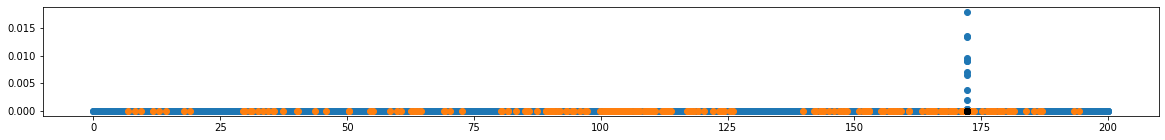

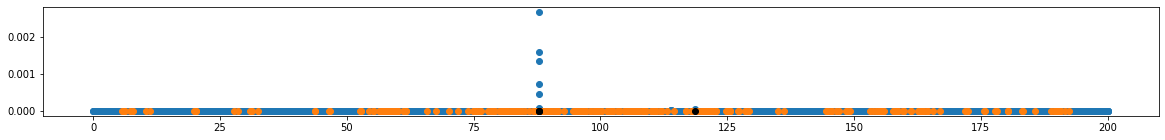

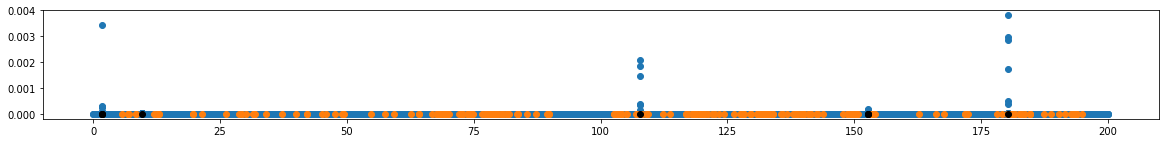

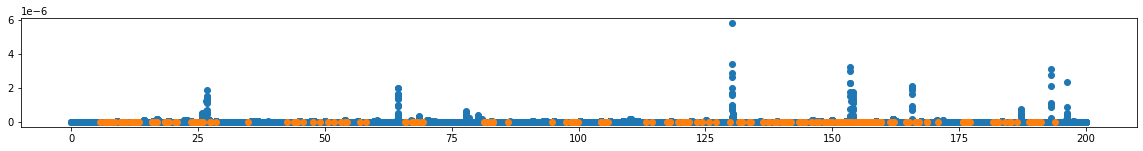

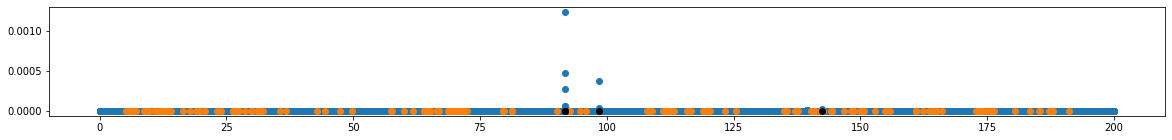

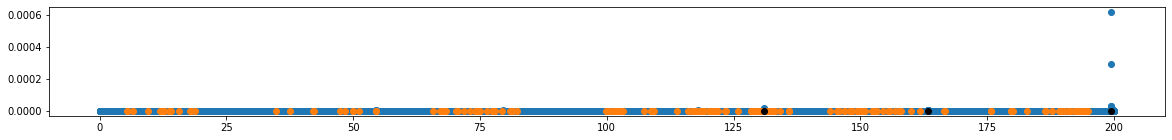

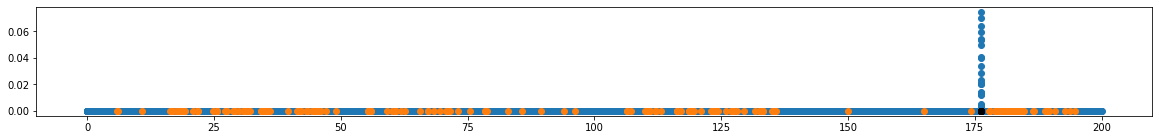

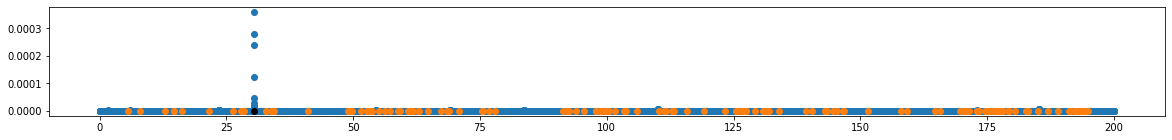

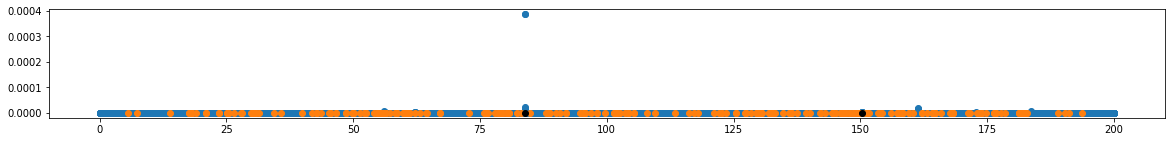

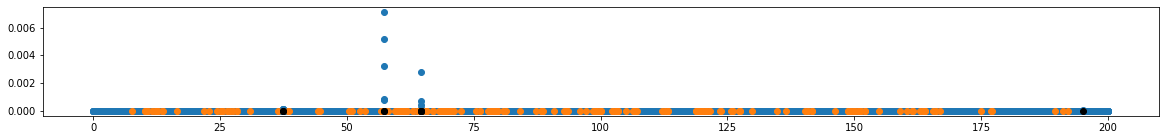

In [9]:
for k in range(10):
    raw_path = 'los.00' + '{0:03}'.format(k) +'.raw'
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
    null = []
    for i in range(len(data[k][1])):
        null.append(0)
    fig = plt.figure(figsize=(20, 2))
    ax = fig.add_subplot(111)
    ax.scatter(distance,HI_density)
    ax.scatter(data[k][1],null)
    null2 = []
    for i in range(len(all_distance[k])):
        null2.append(0)
    ax.scatter(all_distance[k],null2,color = "black")
    null = []
    null2 = []

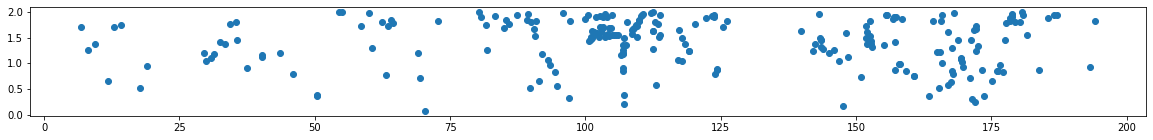

In [10]:
raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
#distance away vs. distance alone
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.scatter(data[0][1],data[0][2])

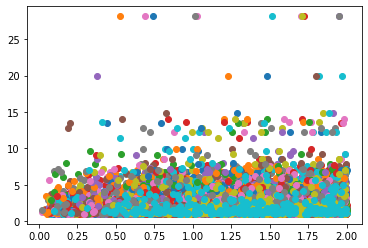

In [11]:
for k in range(100):
    raw_path = 'los.00' + '{0:03}'.format(k) +'.raw'
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
    #sfr vs. distance away, lower mass means closer to the los

    #gives sfr, distance along LOS, and distance away from LOS
    plt.scatter(data[k][2],data[k][0])

In [12]:
##data is:gives sfr, distance along LOS, and distance away from LOS
#I am just going to simply look at distance vs sfr right here, any thing within 2 chimp away form the lls is counted as a galaxy associated with it
def associated(all_distance,data,counts):
    ##going through every los
    associated = []
    for i in range(counts):
        ##going through the lls in the los
        for k in all_distance[i]:
            ##calculating the distance of every galaxy's relationship with lls
            for z in range(len(data[i][1])):
                if(np.sqrt(data[i][2][z]**2 + (abs(k-data[i][1][z]))**2)<1.5):
                    associated.append([i,k,data[i][0][z],data[i][1][z],data[i][2][z],np.sqrt(data[i][2][z]**2 + (abs(k-data[i][1][z]))**2)])
    return associated


In [13]:
##data is:gives sfr, distance along LOS, and distance away from LOS
#I am just going to simply look at distance vs sfr right here, any thing within 2 chimp away form the lls is counted as a galaxy associated with it
def associated(all_distance,data,counts):
    ##going through every los
    associated = []
    for i in range(counts):
        ##going through the lls in the los
        for k in all_distance[i]:
            ##calculating the distance of every galaxy's relationship with lls
            for z in range(len(data[i][1])):
                if((abs(k-data[i][1][z])**2)<1.5):
                    associated.append([i,k,data[i][0][z],data[i][1][z],data[i][2][z],abs(k-data[i][1][z])])
    return associated

In [14]:

associated = associated(all_distance,data,100)

In [15]:
associated

[[0, 172.16311, 1.081, 172.19072623, 1.72637096, 0.02761623000000668],
 [0, 172.16311, 1.178, 172.1103418, 1.66598399, 0.05276820000000271],
 [0, 172.16311, 1.216, 172.53479572, 1.33482027, 0.3716857200000163],
 [0, 172.16311, 1.346, 172.11200055, 1.23952746, 0.051109449999984236],
 [0, 172.16311, 1.347, 171.09258057, 0.7150856, 1.0705294299999935],
 [0, 172.16311, 1.581, 171.14947676, 1.45201867, 1.01363323999999],
 [0, 172.16311, 1.855, 171.46437706, 0.30666356, 0.6987329399999851],
 [0, 172.16311, 1.867, 173.28103106, 0.87666982, 1.1179210600000147],
 [0, 172.16311, 2.535, 171.94221535, 0.24965871, 0.2208946499999911],
 [0, 172.16311, 2.971, 171.83771388, 1.65121907, 0.3253961199999935],
 [0, 172.17328, 1.081, 172.19072623, 1.72637096, 0.017446229999990237],
 [0, 172.17328, 1.178, 172.1103418, 1.66598399, 0.06293820000001915],
 [0, 172.17328, 1.216, 172.53479572, 1.33482027, 0.3615157199999999],
 [0, 172.17328, 1.346, 172.11200055, 1.23952746, 0.06127945000000068],
 [0, 172.17328, 1

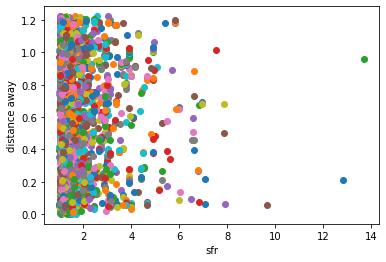

In [16]:
plt.xlabel("sfr")
plt.ylabel("distance away")
for i in range (len(associated)):
    plt.scatter(associated[i][2],associated[i][5])

In [17]:
#bin the sfr